# Installation
First, setup the prerequest for **PyQMRI**:

In [ ]:
!apt-get update
!apt-get install libclfft-dev -y

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libc

In [ ]:
!git clone https://github.com/geggo/gpyfft.git

fatal: destination path 'gpyfft' already exists and is not an empty directory.


In [ ]:
!pip install gpyfft/.

Processing ./gpyfft
  Created wheel for gpyfft: filename=gpyfft-0.7.3-cp36-cp36m-linux_x86_64.whl size=367757 sha256=609c21b4b3d4d1516f80522ca6085730f8f1b3ac6831e3e50ef0ae94f0c4ec8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-hgbwtlsh/wheels/59/8e/ab/202c7b2221f0b7acf0f9b0f7ce9c9c7697830acdd5bd6d7aa5
Successfully built gpyfft
  Found existing installation: gpyfft 0.7.3
    Uninstalling gpyfft-0.7.3:
      Successfully uninstalled gpyfft-0.7.3


After the successfull installation of the prerequests, we can install **PyQMRI** itself:

In [ ]:
!pip install pyqmri

And that was it already. **PyQMRI** is installed on the system. 
# Example data
Next, lets have a look at some example data to run the reconstruction with. We will use *radially acquired VFA* data consisting of 10 *flip angles* (Scans) and 34 *radial projections* each. 

Downloading this file might take some time, depending on the speed of the internet connection.

In [ ]:
import os
%cd sample_data/
if not os.path.isfile("23052018_VFA_34.h5"):
  !wget https://zenodo.org/record/1410918/files/23052018_VFA_34.h5
%cd ..

/content/sample_data
--2020-11-03 14:46:43--  https://zenodo.org/record/1410918/files/23052018_VFA_34.h5
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1688253784 (1.6G) [application/octet-stream]
Saving to: ‘23052018_VFA_34.h5’

23052018_VFA_34.h5  100%[===================>]   1.57G  9.43MB/s    in 3m 0s   

2020-11-03 14:49:44 (8.93 MB/s) - ‘23052018_VFA_34.h5’ saved [1688253784/1688253784]

/content


Ok so we have some data now. Lets explore what is inside of this .h5 file:

In [ ]:
import h5py

with h5py.File('sample_data/23052018_VFA_34.h5', 'r') as file:
  print("Data content: " + str(file.keys()))
  print("Additional (sequence related) attributes: " + str(file.attrs.keys()))

Data content: <KeysViewHDF5 ['Coils', 'dcf', 'fa_corr', 'imag_dat', 'imag_traj', 'real_dat', 'real_traj']>
Additional (sequence related) attributes: <KeysViewHDF5 ['TR', 'data_normalized_with_dcf', 'flip_angle(s)', 'image_dimensions']>


Now we know what to expect. This File reflects the rawdata and necessary attributes to start the reconstruction/fitting process of PyQMRI. 

The data was acquired in a non-Cartesian fashion, as can be seen from the fact that *_traj* entries exists in the data itself.

Visualizing the data and trajectory gives:


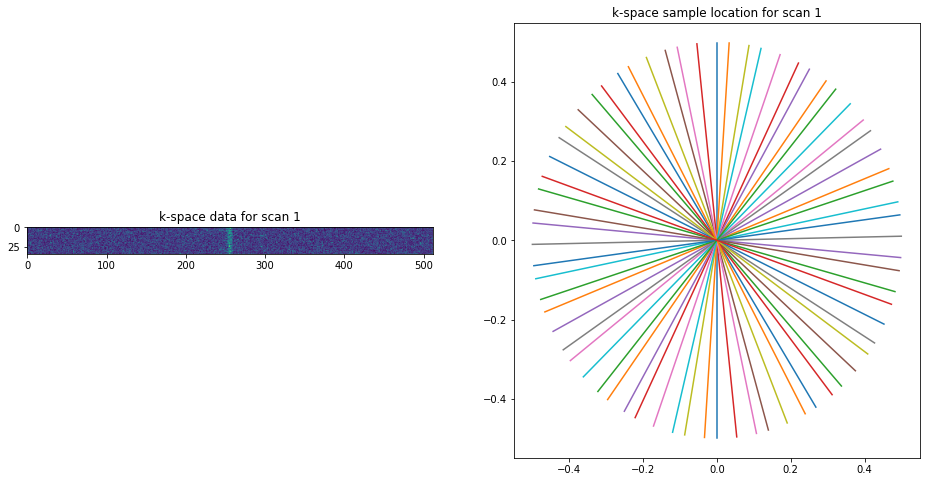

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with h5py.File('sample_data/23052018_VFA_34.h5', 'r') as file:
  data = file["real_dat"][()] + 1j* file["imag_dat"][()]
  trajectory = file["real_traj"][()] + 1j* file["imag_traj"][()]

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.imshow(np.abs(data[0,0,0]))
tmp = plt.title("k-space data for scan 1")
ax = fig.add_subplot(122)
trajectory.shape
plot = ax.plot(trajectory[0].real.T, trajectory[0].imag.T)
tmp = plt.title("k-space sample location for scan 1")



As this file served as input for an older version we need to deleted to old coil sensitivity profiles *Coils* because they will have a wrong orientation.

In [ ]:
with h5py.File('sample_data/23052018_VFA_34.h5', 'r+') as file:
  del file["Coils"]

Lets check if that was succesfull:

In [ ]:
with h5py.File('sample_data/23052018_VFA_34.h5', 'r') as file:
  print("Data content: " + str(file.keys()))
  print("Additional (sequence related) attributes: " + str(file.attrs.keys()))

Data content: <KeysViewHDF5 ['dcf', 'fa_corr', 'imag_dat', 'imag_traj', 'real_dat', 'real_traj']>
Additional (sequence related) attributes: <KeysViewHDF5 ['TR', 'data_normalized_with_dcf', 'flip_angle(s)', 'image_dimensions']>


Perfect. The old coil sensitivity maps are gone and we are ready to start the fitting. As a quick side note, the *dcf* entry is also depracted and will not be used in the current version. We do not need to delete it, as it is not read in at all.




# Starting the fitting with **PyQMRI**
Now we have two possibilities to start the reconstruction, either we use the command line interface or we start it from within the Python interpreter. But first we need to start an ipython cluster which is used for a distributed estimation of coil sensitivity profiles (each slice separate in a process):

In [ ]:
!ipcluster start --daemonize
import time
time.sleep(5) # Wait 5 seconds for the cluster to start

Lets first have a look at the command line interface. Using *--help* we can see what flags we can pass.

In [ ]:
!pyqmri --help

usage: pyqmri [-h] [--recon_type TYPE] [--reg_type REG] [--slices SLICES]
              [--trafo TRAFO] [--streamed STREAMED] [--par_slices PAR_SLICES]
              [--data FILE] [--config CONFIG] [--imagespace IMAGESPACE]
              [--sms SMS] [--OCL_GPU USE_GPU]
              [--devices [DEVICES [DEVICES ...]]] [--dz DZ]
              [--weights [WEIGHTS [WEIGHTS ...]]] [--useCGguess USECG]
              [--out OUTDIR] [--model SIG_MODEL] [--modelfile MODELFILE]
              [--modelname MODELNAME] [--outdir OUTDIR]
              [--double_precision DOUBLE_PRECISION]

T1 quantification from VFA data. By default runs 3D regularization for TGV.

optional arguments:
  -h, --help            show this help message and exit
  --recon_type TYPE     Choose reconstruction type (currently only 3D)
  --reg_type REG        Choose regularization type (default: TGV) options are:
                        TGV, TV, all
  --slices SLICES       Number of reconstructed slices (default=40).
        

With that, lets try to start the reconstruction. First we generate a default configuration file in the current folder which we can later edit. We can have a look at the File using pythons configparser:

In [ ]:
import pyqmri
pyqmri._helper_fun._utils.gen_default_config()

import configparser
config = configparser.ConfigParser()
config.read('default.ini')
print(config.sections())


['TGV', 'TV']


We can see that the file contains two sections *TGV* and *TV* which are used for the regularization associated with each of them. Both are build up the same way and only differ in the values for the regularization strength. Lets examine the TGV part:

In [ ]:
config.items('TGV')

[('max_iters', '1000'),
 ('start_iters', '10'),
 ('max_gn_it', '7'),
 ('lambd', '1e2'),
 ('gamma', '5e-2'),
 ('delta', '1e-1'),
 ('omega', '0'),
 ('display_iterations', '0'),
 ('gamma_min', '5e-3'),
 ('delta_max', '1e2'),
 ('omega_min', '0'),
 ('tol', '1e-6'),
 ('stag', '1e10'),
 ('delta_inc', '10'),
 ('gamma_dec', '0.5'),
 ('omega_dec', '0.5')]

We can see all kind of optimization related values, e.g. number of iteration to use or regularization strength. For now, lets just enable plotting and save the file:

In [ ]:
config.set('TGV', 'display_iterations', '1')
with open('default.ini', 'w') as f:
  config.write(f)

With that we can start a reconstruction/fitting process within Python by:

Unknown command line arguments passed: ['-f', '/root/.local/share/jupyter/runtime/kernel-cfc11e8e-c256-4149-a90f-aabb096a9e7a.json']. These will be ignored for fitting.
Using provied flip angle correction.
GPU OpenCL platform <NVIDIA CUDA> found with 1 device(s) and OpenCL-version <OpenCL 1.2 CUDA 10.1.152>
Using single precision
Using single precision
Using single precision
Estimated SNR from kspace 26336.412
Data scale:  314.33432
Using single precision
Initial Norm:  491.0632
Initial Ratio:  [ 25.611603 490.39487 ]
Norm after rescale:  491.06323
Ratio after rescale:  [347.23416 347.23413]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 298.904084
Costs of T(G)V: 0.000000
Costs of L2 Term: 701.095916
---------------------------------------------------------------------------
Function value at GN-Step 0: 1000.000000
---------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pyqmri/solver.py:895: RuntimeWarning: divide by zero encountered in double_scalars
  self._DTYPE_real(1 / (1 + par[0] / par[3])),


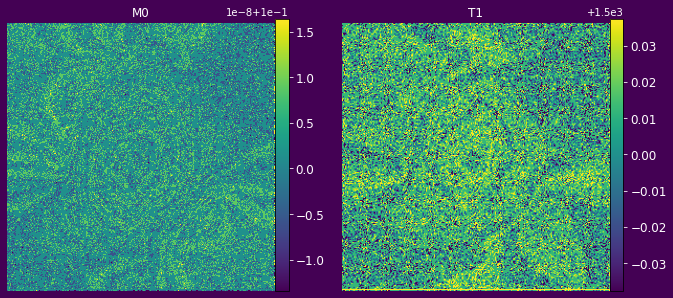

---------------------------------------------------------------------------
GN-Iter: 0  Elapsed time: 6.671120 seconds
---------------------------------------------------------------------------
Initial Norm:  307.5716
Initial Ratio:  [259.0445  165.81989]
Norm after rescale:  307.5716
Ratio after rescale:  [217.486   217.48593]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 15.180288
Costs of T(G)V: 0.471494
Costs of L2 Term: 53.523239
---------------------------------------------------------------------------
Function value at GN-Step 1: 69.175021
---------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

---------------------------------------------------------------------------
GN-Iter: 1  Elapsed time: 7.632198 seconds
---------------------------------------------------------------------------
Initial Norm:  244.77806
Initial Ratio:  [229.84364  84.19142]
Norm after rescale:  244.77806
Ratio after rescale:  [173.08423 173.08423]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 3.305516
Costs of T(G)V: 0.255211
Costs of L2 Term: 2.603047
---------------------------------------------------------------------------
Function value at GN-Step 2: 6.163775
---------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

---------------------------------------------------------------------------
GN-Iter: 2  Elapsed time: 14.005931 seconds
---------------------------------------------------------------------------
Initial Norm:  264.14438
Initial Ratio:  [210.42711 159.6643 ]
Norm after rescale:  264.1444
Ratio after rescale:  [186.77832 186.77827]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 2.350412
Costs of T(G)V: 0.136699
Costs of L2 Term: 0.222330
---------------------------------------------------------------------------
Function value at GN-Step 3: 2.709440
---------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Terminated at iteration 30 because the energy decrease in the primal problem was less than 4.822e-07
---------------------------------------------------------------------------
GN-Iter: 3  Elapsed time: 11.410784 seconds
---------------------------------------------------------------------------
Initial Norm:  275.24033
Initial Ratio:  [194.6561 194.5925]
Norm after rescale:  275.24033
Ratio after rescale:  [194.6243  194.62431]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 2.255412
Costs of T(G)V: 0.167106
Costs of L2 Term: 0.222241
---------------------------------------------------------------------------
Function value at GN-Step 4: 2.644759
---------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

---------------------------------------------------------------------------
GN-Iter: 4  Elapsed time: 53.036350 seconds
---------------------------------------------------------------------------
Initial Norm:  311.4288
Initial Ratio:  [241.32141 196.85497]
Norm after rescale:  311.4288
Ratio after rescale:  [220.21347 220.21338]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 2.256774
Costs of T(G)V: 0.136053
Costs of L2 Term: 0.198378
---------------------------------------------------------------------------
Function value at GN-Step 5: 2.591205
---------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Terminated at iteration 70 because the energy decrease in the primal problem was less than 1.929e-07
---------------------------------------------------------------------------
GN-Iter: 5  Elapsed time: 24.623435 seconds
---------------------------------------------------------------------------
Initial Norm:  314.40265
Initial Ratio:  [225.6203  218.96234]
Norm after rescale:  314.40262
Ratio after rescale:  [222.31625 222.31622]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 2.230266
Costs of T(G)V: 0.163726
Costs of L2 Term: 0.195346
---------------------------------------------------------------------------
Function value at GN-Step 6: 2.589338
---------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Terminated at iteration 130 because the energy decrease in the primal problem was less than 9.148e-07
---------------------------------------------------------------------------
GN-Iter: 6  Elapsed time: 43.807075 seconds
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 2.230266
Costs of T(G)V: 0.150245
Costs of L2 Term: 0.195236
---------------------------------------------------------------------------
Function value at GN-Step 7: 2.575747
---------------------------------------------------------------------------


In [ ]:
pyqmri.run(data='sample_data/23052018_VFA_34.h5', model='VFA', slices=1)

or directly from the command line via:

In [ ]:
!pyqmri --data sample_data/23052018_VFA_34.h5 --trafo 1 --slices 1 --reg_type TGV --config default --model VFA

Using provied flip angle correction.
GPU OpenCL platform <NVIDIA CUDA> found with 1 device(s) and OpenCL-version <OpenCL 1.2 CUDA 10.1.152>
Using precomputed coil sensitivities
Using precomputed images
Estimated SNR from kspace 26336.412
Data scale:  314.33432
Using single precision
Initial Norm:  491.0632
Initial Ratio:  [ 25.611603 490.39487 ]
Norm after rescale:  491.06323
Ratio after rescale:  [347.23416 347.23413]
---------------------------------------------------------------------------
Initial Cost: 2569.238114
Costs of Data: 298.904084
Costs of T(G)V: 0.000000
Costs of L2 Term: 701.095916
---------------------------------------------------------------------------
Function value at GN-Step 0: 1000.000000
---------------------------------------------------------------------------
/usr/local/lib/python3.6/dist-packages/pyqmri/solver.py:895: RuntimeWarning: divide by zero encountered in double_scalars
  self._DTYPE_real(1 / (1 + par[0] / par[3])),
<Figure size 1200x600 with 8 Axes

# **PyQMRI** text-based models

In this section we will have a look at the text-based models. First lets generate a default model-file and examine its content:

In [ ]:
pyqmri.generate_text_models()

with open('models.ini','r') as file:
  for line in file.readlines():
    print(line)

[MonoExp]

parameter = TE

unknowns = M0 A1

signal = M0*exp(-TE*A1)

box_constraints_lower = 0,0

box_constraints_upper = 100,1

real_value_constraints = False,True

guess = 1,0.01

rescale = M0,1/A1

estimate_individual_phase = False



[VFA-E1]

parameter = TR fa fa_corr

unknowns = M0 E_1

signal = M0*sin(fa*fa_corr)*(1-E_1)/(1-E_1*cos(fa*fa_corr))

box_constraints_lower = 0,0.9048

box_constraints_upper = 10,0.99909

real_value_constraints = False,True

guess = 1,0.99667

rescale = M0,-TR/log(E_1)

estimate_individual_phase = False





We see that, similar to the config file, each model is defined via a section, e.g. *[VFA-E1]* for the VFA model. 
Next the *parameters* are describe sequence related parameters that are known a priori. The *unknowns* determine the parameters which should be fit and *signal* describes the relation between signal intensity and sequence/parameters. In additon, boxconstrains and real value constrains can be set for each unknown separately. The initial guess *guess* is meant as constant value for the whole image. *resacle* devines rescaling functions, if only the unknonw itself is given, no additional transformation is used. Finally, *estimate_individual_phase* can be used to estimate phase variations between each scan, e.g. usefully in diffusion imaging. 


Now we also copy the "flip_angle(s)" attribute to "fa". This is necessary because all parameters defined in the model file need to be named the same way in the data attributes section

In [ ]:
import numpy as np
with h5py.File('sample_data/23052018_VFA_34.h5', 'r+') as file:
  file.attrs["fa"] = file.attrs["flip_angle(s)"]/180*np.pi

Lets take a look now at how to invoke the model file, for simplicity, we just use the CLI interface here. Steps from within Python are identical.



In [ ]:
!pyqmri --data sample_data/23052018_VFA_34.h5 --trafo 1 --slices 1 --reg_type TGV --config default --modelfile models.ini --modelname VFA-E1

Using provied flip angle correction.
GPU OpenCL platform <NVIDIA CUDA> found with 1 device(s) and OpenCL-version <OpenCL 1.2 CUDA 10.1.152>
Using precomputed coil sensitivities
Using precomputed images
Estimated SNR from kspace 26336.412
Data scale:  314.33432
Using single precision
Initial Norm:  5064.0312
Initial Ratio:  [  24.441225 5063.972   ]
Norm after rescale:  5064.0317
Ratio after rescale:  [3580.811 3580.811]
---------------------------------------------------------------------------
Initial Cost: 85085.258519
Costs of Data: 978.795790
Costs of T(G)V: 0.000000
Costs of L2 Term: 21.204210
---------------------------------------------------------------------------
Function value at GN-Step 0: 1000.000000
---------------------------------------------------------------------------
/usr/local/lib/python3.6/dist-packages/pyqmri/solver.py:895: RuntimeWarning: divide by zero encountered in double_scalars
  self._DTYPE_real(1 / (1 + par[0] / par[3])),
<Figure size 1200x600 with 8 Axe

# Displaying the results

Finally, lets have a quick look at the results. These are stored in the PyQMRI_out folder next to the input data per default and named after the used model. All reconstructions feature a time stamp to easily distinguis them.

In [ ]:
import os

outdirs_VFA = os.listdir('sample_data/PyQMRI_out/VFA')
outdirs_VFA.sort()

# Lets have a closer look at the most recent one:

files = os.listdir('sample_data/PyQMRI_out/VFA/'+outdirs_VFA[-1])

print(files)
print(outdirs_VFA)

['config.ini', 'output_23052018_VFA_34.h5']
['2020-11-03  14-43-47', '2020-11-03  14-44-19', '2020-11-03  14-49-53', '2020-11-03  14-52-56']


We see that there is a config.ini file along with the output. The config file contains all the parameters used in the reconstruction for this specific dataset. Now we take a closer look at the output:

In [ ]:
with h5py.File('sample_data/PyQMRI_out/VFA/'+outdirs_VFA[-1]+os.sep+files[-1],'r') as file:
  print(file.keys())

<KeysViewHDF5 ['images_ifft', 'tgv_result_iter_0', 'tgv_result_iter_1', 'tgv_result_iter_2', 'tgv_result_iter_3', 'tgv_result_iter_4', 'tgv_result_iter_5', 'tgv_result_iter_6']>


We can see that the file containts several entries. *images_ifft* amounts to iamges based on a simple image reconstruction of the rawdata (either CG-SENSE based or just iFFT). In addition, we have a *tgv_result_iter_x* for each Gauss-Newton iteration of the optimization algorithm. 

As final step, we can visualize the fitting results for this example (*tgv_result_iter_6*) and the initial images after CG-SENSE reconstruction:

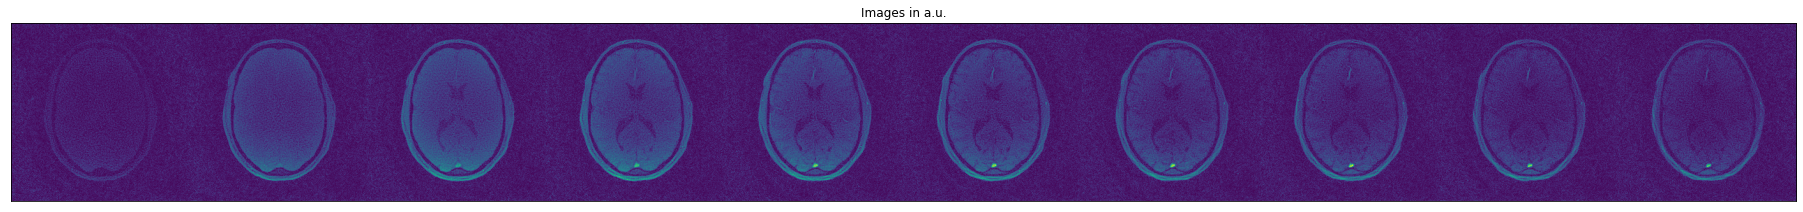

In [ ]:
with h5py.File('sample_data/PyQMRI_out/VFA/'+outdirs_VFA[-1]+os.sep+files[-1],'r') as file:
  result = file["tgv_result_iter_6"][()]
  images = file["images_ifft"][()]

%matplotlib inline

import matplotlib.pyplot as plt

num_images = images.shape[0]
images = np.swapaxes(images, -2, -1)
images = images.reshape(images.shape[-2]*num_images, -1).T
fig = plt.figure(figsize=(32,4))
ax = fig.add_subplot(111)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(np.abs(np.squeeze(images)))
plt.title('Images in a.u.')
plt.show()

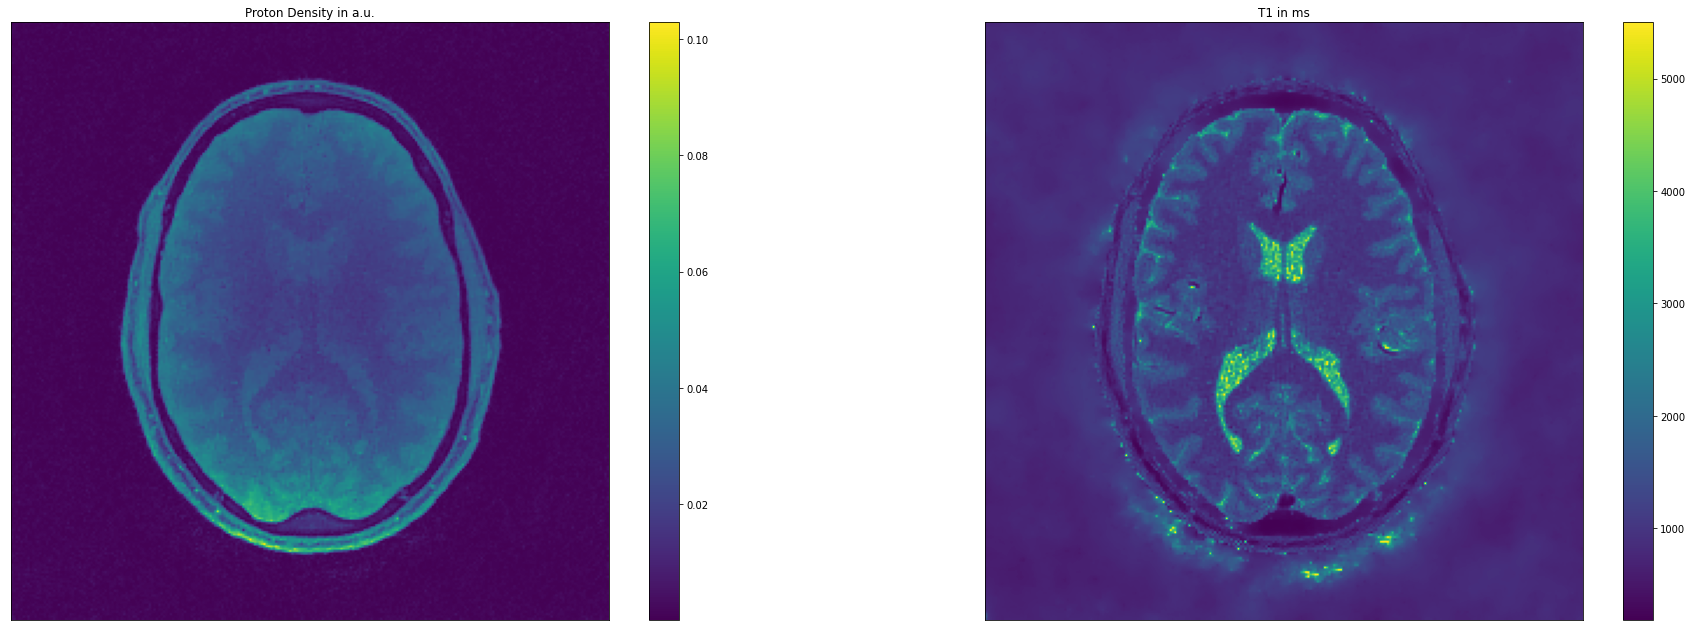

In [ ]:
fig = plt.figure(figsize=(32,11))
ax = fig.add_subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
M0_plot = plt.imshow(np.abs(np.squeeze(result[0])))
cb = plt.colorbar(M0_plot)
tmp = plt.title('Proton Density in a.u.')
ax = fig.add_subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
T1_plot = plt.imshow(np.abs(np.squeeze(result[1])))
cb = plt.colorbar(T1_plot)
tmp = plt.title('T1 in ms')